In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
from settings import*

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [4]:
%pip install pandas
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [43]:
def process_data(train_data_path, test_data_path, delimiter="|"):
    # Load the training and test data
    train_data = pd.read_csv(train_data_path, delimiter=delimiter)
    test_data = pd.read_csv(test_data_path)
    test_data = test_data.drop(columns=["ID", "scaling_factor"])

    # Convert time column to datetime
    train_data['time'] = pd.to_datetime(train_data['time'])

    # Sort the training data by vesselId and time to ensure proper alignment for shifting
    train_data_sorted = train_data.sort_values(by=["vesselId", "time"], ascending=True).copy()

    # Shift latitude and longitude for each vessel to create "previous_lat" and "previous_lon"
    train_data_sorted['previous_lat'] = train_data_sorted.groupby('vesselId')['latitude'].shift(1)
    train_data_sorted['previous_lon'] = train_data_sorted.groupby('vesselId')['longitude'].shift(1)
    
     # Drop rows with NaNs in previous_lat and previous_lon
    train_data_sorted = train_data_sorted.dropna(subset=['previous_lat', 'previous_lon'])

    # Calculate difference for target variables
    #train_data_sorted['lat_diff'] = train_data_sorted['latitude'] - train_data_sorted['previous_lat']
    #train_data_sorted['lon_diff'] = train_data_sorted['longitude'] - train_data_sorted['previous_lon']

    # Get the last entry per vessel in the training data
    last_entries = train_data_sorted.groupby('vesselId').last().reset_index()
    
    # Merge the last row of the training data with the test data based on vesselId
    test_data_merged = test_data.merge(last_entries, on='vesselId', how='left')
    test_data_merged = test_data_merged.drop(columns=['time_y']).rename(columns={'time_x': 'time'})

    return train_data_sorted, test_data_merged

# Usage
train_data_path = AIS_TRAIN # '../data/ais_train.csv'
test_data_path = AIS_TEST # '../data/ais_test.csv'
vessel_info_path = VESSELS  
vessel_info = pd.read_csv(vessel_info_path, delimiter="|")
port_info_path = PORTS  
port_info = pd.read_csv(port_info_path, delimiter="|")
processed_train_data, processed_test_data = process_data(train_data_path, test_data_path)

# To save the processed test data
processed_test_data.head()

,vesselId,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,portId,previous_lat,previous_lon
0,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,179.6,0.0,0,344,5,05-06 10:45,31.14647,-81.49789,61d38499b7b7526e1adf3d54,31.14648,-81.49789
1,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,24.7,0.0,0,214,5,05-01 23:00,14.81694,120.29625,61d37d5799db2ccf7339ef3b,14.81694,120.29624
2,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61d3781293c6feb83e5eb73b,38.14875,10.75635
3,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,321.3,0.1,0,70,1,05-07 01:15,-43.53785,172.83522,61d37bfe99db2ccf7339ece3,-43.53815,172.83516
4,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,291.0,0.3,0,275,2,05-09 04:00,48.53320,-6.12003,61d3743d3aeaecc07011a6fa,48.53133,-6.10750


In [44]:
vessel_info = vessel_info.drop(columns=['draft','freshWater','maxHeight','maxSpeed','maxWidth','rampCapacity','yearBuilt'])
vessel_info = vessel_info.fillna(0)
label_encoder = LabelEncoder()
vessel_info['shippingLineId'] = label_encoder.fit_transform(vessel_info['shippingLineId'].astype(str))
vessel_info['homePort'] = label_encoder.fit_transform(vessel_info['homePort'].astype(str))
vessel_info.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,enginePower,fuel,homePort,length
0,0,61e9f38eb937134a3c4bfd8b,6500,21200.0,58684,17606.0,83.0,32.0,22.20,0.0,0.00,30,199.00
1,25,61e9f38eb937134a3c4bfd8d,4902,12325.0,46800,0.0,83.0,31.0,0.00,14220.0,0.00,22,182.00
2,20,61e9f38eb937134a3c4bfd8f,5000,13059.0,46800,0.0,83.0,31.0,0.00,14220.0,0.00,38,182.00
3,18,61e9f38eb937134a3c4bfd91,4200,12588.0,39362,0.0,83.0,28.0,0.00,11060.0,0.00,0,167.00
4,3,61e9f390b937134a3c4bfd93,7450,21052.0,75528,24391.0,83.0,37.2,22.23,13140.0,3236.78,35,199.98


In [45]:
processed_train_data = processed_train_data.merge(vessel_info, on='vesselId', how='left')
processed_test_data = processed_test_data.merge(vessel_info, on='vesselId', how='left')

In [46]:
port_info = port_info.drop(columns=['name','UN_LOCODE','ISO','countryName','portLocation'])
port_info = port_info.fillna(0)
port_info = port_info.rename(columns={"longitude": "plongitude", "latitude": "platitude"})
port_info.head()

,portId,plongitude,platitude
0,61d36ed80a1807568ff9a064,3.067222,36.773611
1,61d36ed80a1807568ff9a065,7.772500,36.900556
2,61d36edf0a1807568ff9a070,-0.639722,35.712222
3,61d36ee00a1807568ff9a072,6.905833,36.887500
4,61d36ee10a1807568ff9a074,-170.690556,-14.274167


In [47]:
processed_train_data = processed_train_data.merge(port_info, on='portId', how='left')
processed_test_data = processed_test_data.merge(port_info, on='portId', how='left')

In [48]:
# Prepare features and target variables
y_train = processed_train_data[['latitude', 'longitude']].copy()
X_train = processed_train_data.copy()
#X_train = X_train.drop(columns=["longitude", "latitude", "etaRaw", "navstat", "rot", "heading"])

X_train = X_train.drop(columns=['time'])

# Apply the same preprocessing to the test set
X_test = processed_test_data.copy()
#X_test = X_test.drop(columns=["longitude", "latitude", "etaRaw", "navstat", "rot", "heading"])

X_test = X_test.drop(columns=['time'])

# Encode categorical variables 'vesselId' and 'portId' using LabelEncoder
label_encoder = LabelEncoder()
X_train['vesselId'] = label_encoder.fit_transform(X_train['vesselId'].astype(str))
X_test['vesselId'] = label_encoder.transform(X_test['vesselId'].astype(str))  # Use transform to avoid data leakage

X_train['portId'] = label_encoder.fit_transform(X_train['portId'].astype(str))
X_test['portId'] = label_encoder.transform(X_test['portId'].astype(str))# Use transform to avoid data leakage

# Select relevant features for training and testing
X_train = X_train[['cog', 'sog', 'previous_lat', 'previous_lon', 'portId', "heading","vesselId","shippingLineId",
                  "CEU","DWT","GT",'NT',"breadth","homePort","platitude", "plongitude"]]
X_test = X_test[['cog', 'sog', 'previous_lat', 'previous_lon', 'portId', "heading","vesselId","shippingLineId",
                  "CEU","DWT","GT",'NT',"breadth","homePort","platitude", "plongitude"]]


In [ ]:
#juste avec vessel id et pas heading
best_params = {'colsample_bytree': 0.8, 
 'learning_rate': 0.1, 
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 1.0}

   #colsample_bytree = 0.8, 
     #learning_rate = 0.1, 
     #max_depth=  6,
    # min_child_weight= 1,
    # n_estimators= 100,
    # subsample = 1.0
# avec vessil id et heading 
#    {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 4,
 #    'estimator__min_child_weight': 2, 'estimator__n_estimators': 300, 'estimator__subsample': 0.9}
    
    
   #{'estimator__colsample_bytree': 0.9, 'estimator__learning_rate': 0.1,
#'estimator__max_depth': 5, 'estimator__min_child_weight': 2,
#'estimator__n_estimators': 100, 'estimator__subsample': 1.0} 

In [53]:
xreg = xgb.XGBRegressor(colsample_bytree = 0.8, 
     learning_rate = 0.1, 
     max_depth=  6,
    min_child_weight= 1,
     n_estimators= 100,
     subsample = 1)

# Wrap the model in MultiOutputRegressor for multi-target regression
multi_regressor = MultiOutputRegressor(xreg)

#xreg.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
multi_regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [ ]:
# Set up initial values for test data and predictions
#num_steps = 5 * 24  # Assuming predictions are hourly, for five days
#predictions = []

#current_test_data = X_test.copy()
#cumulative_lat_diff = np.zeros(X_test.shape[0])  # Initialize cumulative latitude differences
#cumulative_lon_diff = np.zeros(X_test.shape[0])  # Initialize cumulative longitude differences

#for step in range(num_steps):
#   # Predict next latitude and longitude
#    next_prediction = multi_regressor.predict(current_test_data)
    
 #   # Add current predictions to the list (flattened)
 #   predictions.append(next_prediction)
#    # Update cumulative differences
 #   cumulative_lat_diff += next_prediction[:, 0]  # Accumulate latitude differences
#    cumulative_lon_diff += next_prediction[:, 1]
#    # Update current_test_data with the latest prediction to simulate a one-step-forward
#    current_test_data['lat_diff'] = next_prediction[:, 0]
#    current_test_data['lon_diff'] = next_prediction[:, 1]
    
    # Update time-related features if needed, such as incrementing by an hour or day
#final_predict= np.column_stack((cumulative_lat_diff, cumulative_lon_diff))

In [50]:
#final_predict

array([[-8.14078667e-03,  2.20631736e+01],
       [-5.82518557e-02,  1.35023813e-01],
       [ 1.54962391e+01,  8.05012587e+00],
       ...,
       [ 2.97050714e+00,  1.49239138e+01],
       [-1.76184082e+01, -3.57189310e+01],
       [-1.04923714e-01,  1.50962571e+00]])

In [43]:
# After the loop, convert predictions to a DataFrame for analysis or submission
#predictions_df = pd.DataFrame(final_predict, columns=['latitude_predicted', 'longitude_predicted'])
# Add the ID column, which starts from 0 and increments by 1 for each row
#predictions_df['ID'] = range(len(predictions_df))

# Reorder the columns to ensure 'id' is the first column (if required by the submission format)
#predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save the predictions to a CSV file
#from utils import make_file_name
#from settings import * 

#output_path = SUBMISSION_FODLER.joinpath(make_file_name() + '.csv')
#predictions_df.to_csv(output_path, index=False)

#predictions_df.head()

Submission file name is: 6c1afbc3-c746-4fe1-832d-a7d18a5364fb


,ID,longitude_predicted,latitude_predicted
0,0,22.063174,-0.008141
1,1,0.135024,-0.058252
2,2,8.050126,15.496239
3,3,0.195644,0.675914
4,4,-1.465309,0.714286


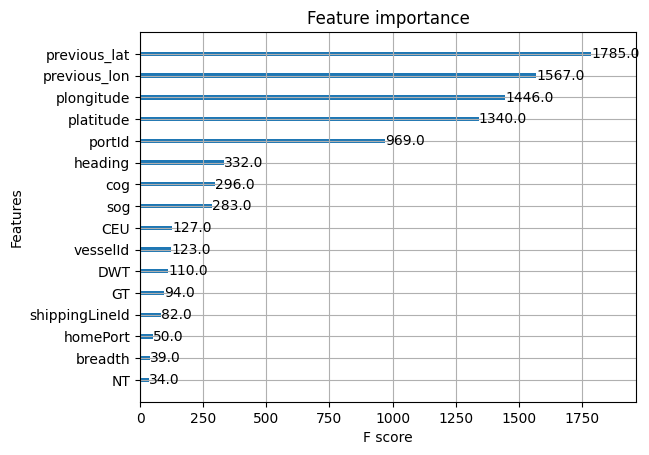

In [50]:
#xgb.plot_importance(booster=xreg ); plt.show()

In [56]:
param_grid = {
    'estimator__n_estimators': [100,150,200],  # Number of boosting rounds
    'estimator__max_depth': [5,6,7],        # Maximum tree depth
    'estimator__learning_rate': [0.01, 0.1,0.15],  # Learning rate (eta)
    'estimator__subsample': [1.0],     # Subsample ratio
    'estimator__min_child_weight': [1,2,3],  # Minimum sum of instance weight needed in a child
    'estimator__colsample_bytree': [0.7,0.8,0.9]  # Subsample ratio of columns when constructing trees
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=multi_regressor,
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    verbose=10,
    n_jobs=-1  # Use all available CPU cores
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 4/5; 1/243] START estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__subsample=1.0
[CV 4/5; 1/243] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__subsample=1.0;, score=0.845 total time=  44.2s
[CV 2/5; 2/243] START estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=150, estimator__subsample=1.0
[CV 2/5; 2/243] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=150, estimator__subsample=1.0;, score=0.939 total time= 1.0min
[CV 1/5; 3/243] START estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimato

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5; 1/243] START estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__subsample=1.0
[CV 2/5; 1/243] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__subsample=1.0;, score=0.850 total time=  43.8s
[CV 1/5; 2/243] START estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=150, estimator__subsample=1.0
[CV 1/5; 2/243] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=150, estimator__subsample=1.0;, score=0.936 total time= 1.0min
[CV 5/5; 2/243] START estimator__colsample_bytree=0.7, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_esti

GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=0.8,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constra...
                                                                   multi_strategy=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=None, ...)),
             n_jobs=-1,
             param_grid={'estimator__colsample_bytree': [0.7, 0.8, 0.9],
                         'estimator__learning_rate': [0.01, 0.1, 0.15],
                         'estimator__max_depth': [5, 6, 7],
                         'estimator__min_child_weight': [1, 2, 3],
                         'estimator__n_estimators': [100, 150, 200],
                         'estimator__subsample': [1.0]},
             verbose=10)

In [58]:
print(grid_search.best_params_)

{'estimator__colsample_bytree': 0.9, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__min_child_weight': 2, 'estimator__n_estimators': 100, 'estimator__subsample': 1.0}


In [59]:
# Make predictions over X_test with result of grid schearch 
y_pred_default = grid_search.predict(X_test)

# Make predictions over X_test with fix params 
#y_pred_default = multi_regressor.predict(X_test)

# Convert the NumPy array to a pandas DataFrame
y_pred_default_df = pd.DataFrame(y_pred_default, columns=['latitude_predicted', 'longitude_predicted'])

# Add the ID column, which starts from 0 and increments by 1 for each row
y_pred_default_df['ID'] = range(len(y_pred_default_df))

# Reorder the columns to ensure 'id' is the first column (if required by the submission format)
y_pred_default_df = y_pred_default_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save the predictions to a CSV file
from utils import make_file_name
from settings import * 

output_path = SUBMISSION_FODLER.joinpath(make_file_name() + '.csv')
y_pred_default_df.to_csv(output_path, index=False)

y_pred_default_df.head()

Submission file name is: 04fe846c-2064-431e-a5fa-1207e500df49


,ID,longitude_predicted,latitude_predicted
0,0,-81.178551,31.184988
1,1,117.704849,14.292438
2,2,10.951176,38.419159
3,3,172.223770,-43.086220
4,4,-6.318208,48.756535
